In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
disp_figs = True

In [243]:
M = 1 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 6 # hz
background_noise_fr = 20 # h

np.random.seed(41)

In [244]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 100 colors (10 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])


# Generate the PG Kernels


In [246]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

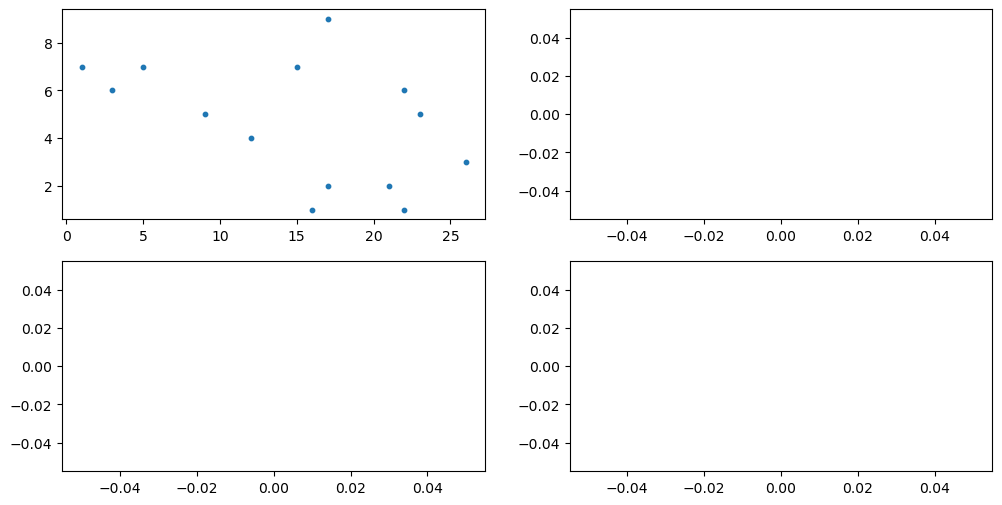

In [247]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences


In [248]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

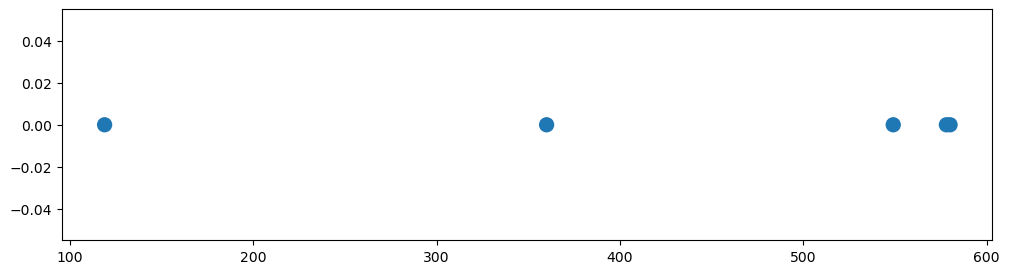

In [249]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [250]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

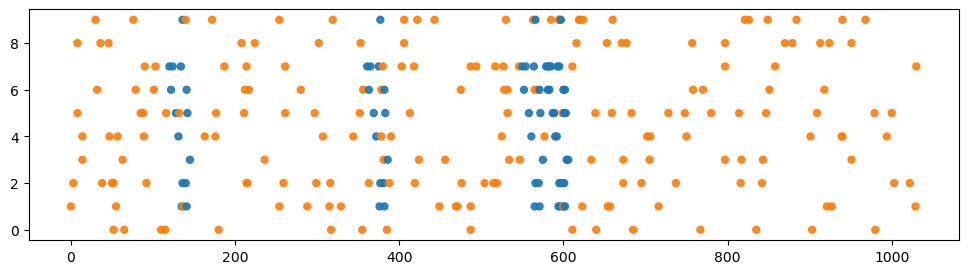

In [251]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

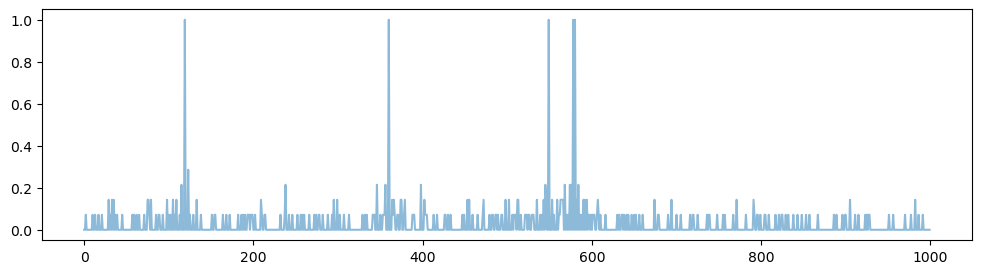

In [252]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 0
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Windowing the data

In [253]:
test_row = 0

In [254]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

In [255]:
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2))
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
#     windows[i,N_labels[i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 251, neurons: 10, depth: 32


In [256]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [257]:
N_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int64)

In [258]:
HDPs = []
sim_mats = []
# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = []
for n in range(N):
    test = windows[N_labels==n]
    if len(test) > 0:
        x = np.zeros((len(test),len(test)))
        for i in range(test.shape[0]):
            for j in range(test.shape[0]):
                x[i,j] = np.sum(test[i]*test[j])/ min(np.sum(test[i]),np.sum(test[j]))
        sim_mats.append(x)
        dissimilarity = 1 - x
        HDPs.append(linkage(dissimilarity, method='complete'))
        clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))

clusters= np.array(clusters)

C:\Users\miles\AppData\Local\Temp\ipykernel_10592\3910738687.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_10592\3910738687.py:18: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


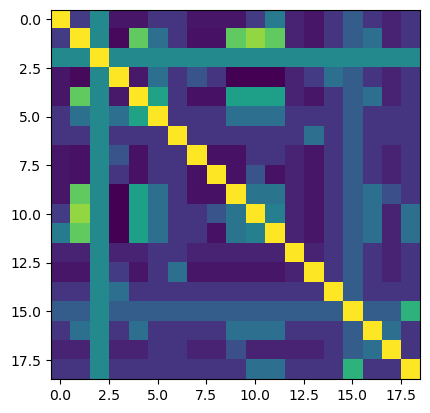

In [259]:
plt.figure()
plt.imshow(sim_mats[3])

In [260]:
clusters

array([  8,  11,   9,  12,   5,   4,  10,   6,   5,   1,   3,   7,   1,
         2,   9,   3, 113, 101, 105, 107, 102, 110, 114, 108, 101, 107,
       115, 103, 104, 112, 101, 107, 101, 104, 106, 106, 107, 108, 111,
       110, 116, 109, 117, 203, 213, 209, 216, 219, 220, 210, 218, 220,
       215, 206, 201, 219, 220, 205, 207, 208, 211, 202, 217, 219, 220,
       219, 219, 220, 220, 204, 214, 212, 215, 216, 304, 310, 312, 308,
       310, 311, 307, 309, 305, 310, 310, 310, 306, 307, 308, 303, 301,
       302, 303, 409, 406, 411, 401, 402, 407, 414, 412, 401, 410, 405,
       404, 401, 402, 401, 401, 406, 403, 405, 412, 413, 408, 515, 503,
       510, 502, 504, 501, 506, 505, 501, 520, 507, 502, 501, 516, 517,
       502, 501, 502, 502, 521, 501, 501, 512, 513, 514, 518, 508, 519,
       520, 509, 511, 512, 615, 609, 606, 601, 603, 605, 613, 602, 608,
       601, 605, 603, 604, 617, 614, 601, 614, 611, 603, 601, 601, 603,
       603, 607, 610, 616, 612, 714, 708, 702, 704, 701, 710, 70

In [261]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

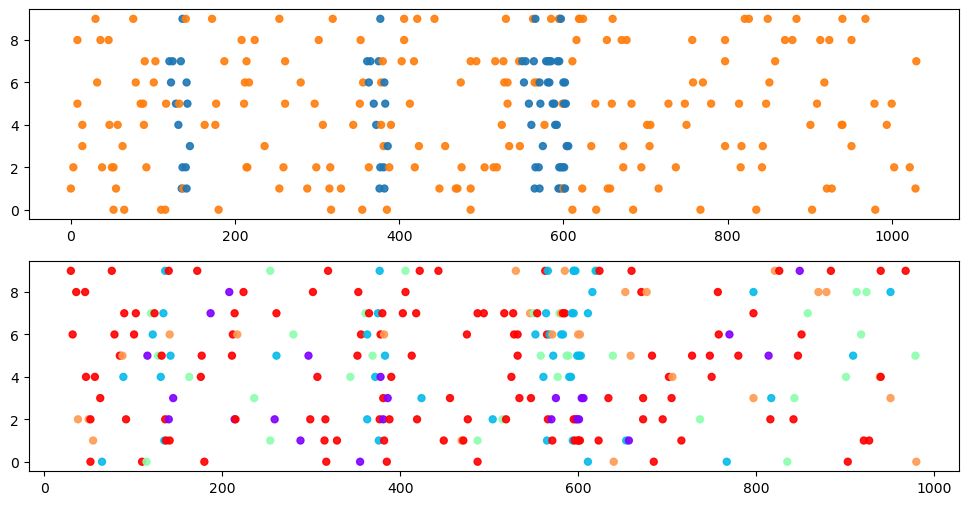

In [262]:
%matplotlib inline
fig,ax = plt.subplot_mosaic('A;B',figsize=(12,6))
ax['A'].scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
ax['B'].scatter(A_sparse[1][valid_spikes],A_sparse[0][valid_spikes],c=cm.rainbow((clusters%10)/np.mean(clusters%10)),alpha=0.9,s=100,marker='.')
plt.show()

In [263]:
time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    time_differences.append(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster])))
    if str(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster]))) in cluster_sq.keys():
        cluster_sq[str(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster])))] + [cluster]
    else: 
        cluster_sq[str(list(np.diff(A_sparse[1][valid_spikes][clusters == cluster])))] = [cluster]
        
new_labels = clusters.copy()
for l, key in enumerate(cluster_sq.keys()):
    for k in cluster_sq[key]:
        new_labels[new_labels == k] = l

import numpy as np
from scipy.optimize import linear_sum_assignment

# Given arrays
labels_array_1 = new_labels.copy()

labels_array_2 = A_sparse[2][valid_spikes].copy()

# for l in np.unique(labels_array_1):
#     if l not in labels_array_2:
#         labels_array_2[labels_array_1 == l] = l



In [265]:
# Get unique labels from both arrays
unique_labels_1 = np.unique(labels_array_1)
unique_labels_2 = np.unique(labels_array_2)

# Create a cost matrix where each entry represents the cost of matching two labels
cost_matrix = np.zeros((len(unique_labels_1), len(unique_labels_2)))

for i, label_1 in enumerate(unique_labels_1):
    for j, label_2 in enumerate(unique_labels_2):
        common_elements = np.logical_and(labels_array_1 == label_1, labels_array_2 == label_2)
        cost_matrix[i, j] = -np.sum(common_elements)

# Use the Hungarian algorithm to find the optimal mapping
row_indices, col_indices = linear_sum_assignment(cost_matrix)

# Map the new labels to the ground truth labels using the optimal mapping
mapped_labels = np.zeros_like(labels_array_1)
for i, j in zip(row_indices, col_indices):
    mapped_labels[labels_array_1 == unique_labels_1[i]] = unique_labels_2[j]


In [266]:
mapped_labels


array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0])

In [267]:
expected_groups=M+1

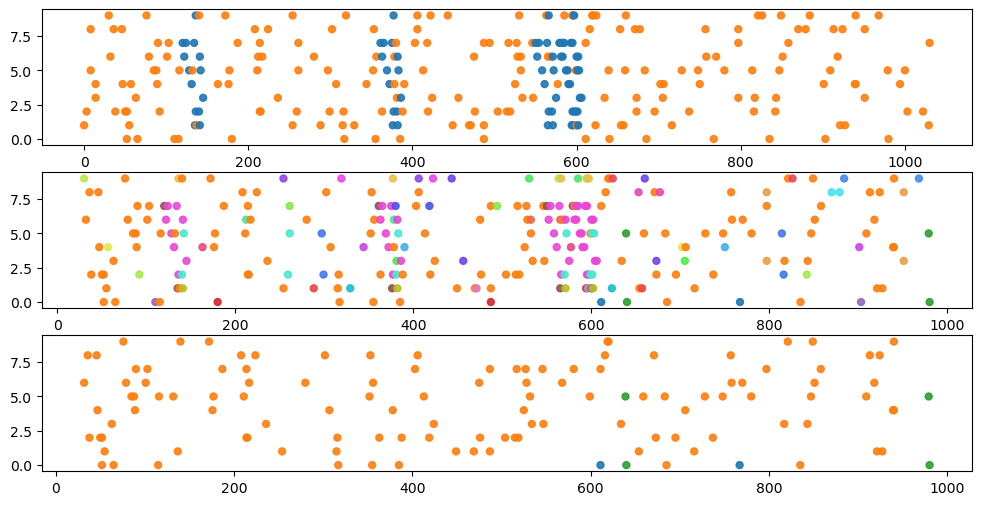

In [268]:
%matplotlib inline
fig,ax = plt.subplot_mosaic('A;B;C',figsize=(12,6))
ax['A'].scatter(A_sparse[1],A_sparse[0],c=palette[A_sparse[2]],alpha=0.9,s=100,marker='.')
ax['B'].scatter(A_sparse[1][valid_spikes],A_sparse[0][valid_spikes],c=palette[new_labels],alpha=0.9,s=100,marker='.')
ax['C'].scatter(A_sparse[1][valid_spikes][new_labels<1+expected_groups],A_sparse[0][valid_spikes][new_labels<1+expected_groups],c=palette[new_labels[new_labels<1+expected_groups]],alpha=0.9,s=100,marker='.')
plt.show()

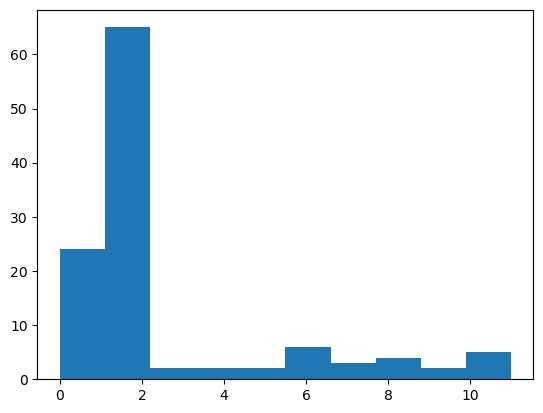

In [148]:
plt.figure()
plt.hist(new_labels)
plt.show()

In [154]:
new_labels[new_labels<=1+expected_groups]

array([0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2,
       2])

In [ ]:
TP = 0
TN = 0
total_TP = 0
total_TN = 0
for m in range(M):
    TP += np.sum(((A_sparse[2][valid_spikes]==m) & (mapped_labels==m)) == True)
    TN += np.sum(((A_sparse[2][valid_spikes]!=m) & (mapped_labels!=m)) == True)
    total_TP += np.sum(A_sparse[2][valid_spikes]==m)
    total_TN += np.sum(A_sparse[2][valid_spikes]!=m)
    
TP/total_TP, TN/total_TN, total_TP,total_TN

In [25]:
# Get unique labels from both arrays
unique_labels_1 = np.unique(labels_array_1)
unique_labels_2 = np.unique(labels_array_2)

# Create a cost matrix where each entry represents the cost of matching two labels
cost_matrix = np.zeros((len(unique_labels_1), len(unique_labels_2)))

for i, label_1 in enumerate(unique_labels_1):
    for j, label_2 in enumerate(unique_labels_2):
        common_elements = np.logical_and(labels_array_1 == label_1, labels_array_2 == label_2)
        cost_matrix[i, j] = -np.sum(common_elements)

# Use the Hungarian algorithm to find the optimal mapping
row_indices, col_indices = linear_sum_assignment(cost_matrix)

# Create a mapping dictionary from the optimal mapping
mapping_dict = {unique_labels_1[i]: unique_labels_2[j] for i, j in zip(row_indices, col_indices)}

# Map the labels from labels_array_1 to labels_array_2 using the mapping dictionary
mapped_labels = np.array([mapping_dict[label] for label in labels_array_1])

print(mapped_labels)
print(A_sparse[2])
print(new_labels)
scat_colors = mapped_labels.copy()
scat_colors[scat_colors >= M] = M
scat_colors

KeyError: 1

In [ ]:
np.sum(((A_sparse[2][valid_spikes]==m) & (mapped_labels==m)) == True)

In [ ]:
mapped_labels==m

In [ ]:
A_sparse[2][A_sparse[2]==m]

In [154]:
accuracy = np.sum(A_sparse[2]==mapped_labels)/len(A_sparse[2])
accuracy

C:\Users\miles\AppData\Local\Temp\ipykernel_10312\3825156868.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(A_sparse[2]==mapped_labels)/len(A_sparse[2])


0.0